In [1]:
import pickle
import itertools
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pathlib

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
## mask.csvように書き換える
class Camera:
    def __init__(self, img_num, f=8000 / 3, cx=1920 / 2, cy=1080 / 2):
        self.img_num = img_num  # カメラ番号（int;コンストラクタ）

        A = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])

        self.A = A  # 内部パラメータ(ndarray)後から更新

    def img_load(self, dir_path):
        """_summary_

        Args:
            file_path (_type_): _description_

        TODO: 画像を1チャネルに変える
        """
        img_list = []
        for i in range(8):
            file_path = os.path.join(dir_path, "{}_{}.png".format(self.img_num, i))
            img = cv2.imread(file_path, 1)  # BGRで読み込み
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.flip(img, 1)
            img_list.append(img)
        self.img = img_list  # 画像(ndarray)
        self.img_shape = img.shape

    def contour_extraction(
        self,
        labels=[
            [255, 0, 0],
            [0, 255, 0],
            [0, 0, 255],
            [255, 255, 0],
            [255, 0, 255],
            [0, 255, 255],
            [127, 127, 127],
            [127, 0, 127]
        ],
    ):
        """Extract contours based on their labels (colors)

        Args:
            labels (_type_): _description_

        TODO: 画像を1チャネルに変える
        """

        n_labels = len(labels)
        color_arr = np.array(labels, dtype=np.int16)
        masks = np.ones(
            (self.img[0].shape[0], self.img[0].shape[1], n_labels), dtype=np.uint8
        )

        for i, color in enumerate(color_arr):
            lower = np.clip(color, 0, 255)
            upper = np.clip(color, 0, 255)
            img_mask = cv2.inRange(self.img[i], lower, upper)
            masks[:, :, i] = img_mask

        self.masks = masks # 色ごとのマスク(nd.array)

        contour_list = []

        # 色ごとに輪郭（閉曲線）を抽出
        for i in range(masks.shape[2]):
            contours, hierarchy = cv2.findContours(
                masks[:, :, i], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
            )
            contour_list.append(contours)
        self.contour_list = contour_list  # 輪郭のリスト(list,ndarray)

    def para_load(self, file_path):
        self.Rt = np.loadtxt(file_path, delimiter="\t")
        self.P = np.dot(self.A, self.Rt[0:3, 0:4])
        self.cam_world_cood = -np.dot(self.Rt[0:3, 0:3].T, self.Rt[0:3, 3])


In [3]:
def norm(vec):
    s_vec = np.square(vec)
    sume = np.sum(s_vec)
    ss = np.sqrt(sume)
    return vec/ss

In [4]:
class LabelProp:
    
    def __init__(self, val, pcd, labels, img_folder_path, view_mat_folder_path):
        self.num = val
        self.LABELS = labels
        self.PCD = pcd
        self.im_path = img_folder_path
        self.view_path = view_mat_folder_path
        
    def cam_load(self):
        test = Camera(self.num)
        test.img_load(self.im_path)

        test.contour_extraction()
        test.para_load(os.path.join(self.view_path, "{}.csv".format(str(self.num))))
        self.cam = test
    
    def point_cloud_load(self):
        self.pcd = self.PCD
        self.labels = self.LABELS
    
    def pc_prop(self):
        # 点群加工
        camera = self.cam.cam_world_cood   
        diameter = np.linalg.norm(
            np.asarray(self.pcd.get_max_bound()) - np.asarray(self.pcd.get_min_bound()))
        #camera = cam_world_cood
        radius = diameter*10000

        _, pt_map = self.pcd.hidden_point_removal(camera, radius)
        self.pcd = self.pcd.select_by_index(sorted(pt_map))

        self.TD_points = np.concatenate([np.asarray(self.pcd.points), np.ones((np.asarray(self.pcd.points).shape[0],1))], axis=1)
        self.labels = self.labels[np.array(sorted(pt_map))]
        
    def pc_labeling(self):
        repro_points = normalization((self.cam.P@self.TD_points.T).T)
        repro_points = np.round(repro_points).astype(np.int64)
        
        idx = (repro_points[:,0]>0) & (repro_points[:,0]<self.cam.img_shape[1]) & (repro_points[:,1]>0) & (repro_points[:,1]<self.cam.img_shape[0])
        
        self.repro_points = repro_points[idx]
        self.labels = self.labels[idx]
        
    def labeling(self):
        overrap_list = np.zeros((labels.max().astype(int)+1 , self.cam.masks.shape[2]))
        for j in np.unique(self.labels):
            temp_overrap_list = []
            zero_mask = np.zeros([self.cam.masks.shape[0],self.cam.masks.shape[1]])
            zero_mask[self.repro_points[self.labels==j][:,1], self.repro_points[self.labels==j][:,0]] = 1
            for i in range(self.cam.masks.shape[2]):
                temp_overrap_list.append(np.sum((zero_mask>0) * (self.cam.masks[:,:,i]>0)))
            overrap_list[int(j),:] = np.array(temp_overrap_list)
        self.output_label = np.argmax(overrap_list,axis=0)

def normalization(vec3):
    return np.array([vec3[:,0]/vec3[:,2], vec3[:,1]/vec3[:,2]]).T

        
def prop_all(num, pcd, labels, img_folder_path, view_mat_folder_path):
    lp = LabelProp(num, pcd, labels, img_folder_path, view_mat_folder_path)
    lp.cam_load()
    lp.point_cloud_load()
    lp.pc_prop()
    lp.pc_labeling()
    lp.labeling()
    return lp.output_label

In [5]:
def rotation_mat(angle):
    Rx = np.array([[1,0,0],
                 [0, np.cos(angle[0]), -np.sin(angle[0])],
                 [0, np.sin(angle[0]), np.cos(angle[0])]])

    Ry = np.array([[np.cos(angle[1]), 0, np.sin(angle[1])],
                 [0,1,0],
                 [-np.sin(angle[1]), 0, np.cos(angle[1])]])

    Rz = np.array([[np.cos(angle[2]), -np.sin(angle[2]), 0],
                 [np.sin(angle[2]), np.cos(angle[2]), 0],
                 [0,0,1]])
    return Rz@Rx@Ry
angle = [np.pi, np.pi, 0] # pcd.rotate()
#angle = [-np.pi/2, np.pi/2, np.pi/2]
R = rotation_mat(angle)
R_mirror = np.array([[-1,0,0],
                    [0,1,0],
                    [0,0,1]])

def clustering(mesh_path):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    pcd = mesh.sample_points_uniformly(number_of_points=50000)
    pcd.rotate(R,(0,0,0))
    points = np.asarray(pcd.points)
    points = points[:,[0,2,1]]
    pcd.points = o3d.utility.Vector3dVector(points)

    labels = np.array(pcd.cluster_dbscan(eps=0.17, min_points=100))
    
    pcd.scale(0.1,(0,0,0))
    #pcd.points = o3d.utility.Vector3dVector((np.asarray(pcd.points)/10))
    max_label = labels.max()
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    return labels, pcd
#o3d.visualization.draw_geometries([pcd])

In [6]:
import pathlib

In [7]:
folder_path = pathlib.Path("polygon/quan_e_a")
mesh_path = list(folder_path.glob("*.ply"))

In [ ]:
output = "labels/q_e_l_noise_3mm/"

for mesh in mesh_path:
    labels, pcd = clustering(str(mesh))
    image_folder = pathlib.Path("C:/home/study/git_test/curve_sketch/simlation_data/images/quan_equidistant/{}".format(mesh.stem))
    image_num_folder = list(image_folder.glob("*"))
    os.makedirs(os.path.join(output, mesh.stem), exist_ok=True)
    
    for image_num_path in image_num_folder:
        img_num = int(image_num_path.stem)
        view_mat_path = pathlib.Path("C:/home/study/git_test/curve_sketch/simlation_data/view_mats/q_e_noise_3mm/view_mat_{}".format(str(img_num)))
        l = []
        for i in range(img_num): 
            label = prop_all(i, pcd, labels, str(image_num_path), str(view_mat_path))
            l.append(label)
            #print(label)
        with open(os.path.join(output, '{}/{}_{}_label.pickle'.format(
            mesh.stem, mesh.stem, str(img_num))), 'wb') as f:
            pickle.dump(l, f)
        

In [45]:
for i in range(16): 
    labels, pcd = clustering('polygon/quan/q_1.ply')
    label = prop_all(i, pcd, labels, 
                     "C:/home/study/git_test/curve_sketch/simlation_data/images/quan_equidistant/q_1/16/",
                     "C:/home/study/git_test/curve_sketch/simlation_data/view_mats/quan_e/view_mat_16_e/")
    l.append(label)

In [46]:
with open(os.path.join(output, 'q_1/q_1_16_e_label.pickle'), 'wb') as f:
    pickle.dump(l, f)

In [ ]:
# 以下検証用（シミュレーションデータの回転検証のために取っておく）

In [268]:
i = 0
test = Camera(i)
test.img_load("C:/home/study/git_test/curve_sketch/simlation_data/images/quantitative/q_1/16/{}.png".format(str(i)))
test.contour_extraction()
test.para_load("C:/home/study/git_test/curve_sketch/simlation_data/view_mats/view_mat_16/{}.csv".format(str(i)))

In [269]:
# クラスタリング
labels, pcd = clustering('polygon/quan/q_1.ply')

max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
#o3d.visualization.draw_geometries([pcd])

In [270]:
# 点群加工
#camera = np.array((test.cam_world_cood[0], test.cam_world_cood[2], test.cam_world_cood[1]))
camera = test.cam_world_cood
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))

#camera = cam_world_cood
radius = diameter*10000

_, pt_map = pcd.hidden_point_removal(camera, radius)
pcd = pcd.select_by_index(sorted(pt_map))

TD_points = np.concatenate([np.asarray(pcd.points), np.ones((np.asarray(pcd.points).shape[0],1))], axis=1)

labels = labels[np.array(sorted(pt_map))]
o3d.visualization.draw_geometries([pcd,])

In [271]:
test.cam_world_cood

array([ 2.49998715,  2.50000126, -0.        ])

In [272]:
repro_points = normalization((test.P@TD_points.T).T)
repro_points = np.round(repro_points).astype(np.int64)

In [273]:
idx = (repro_points[:,0]>0) & (repro_points[:,0]<test.img_shape[1]) & (repro_points[:,1]>0) & (repro_points[:,1]<test.img_shape[0])

In [274]:
repro_points = repro_points[idx]
labels = labels[idx]

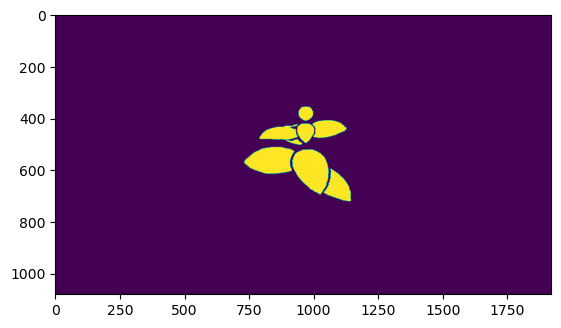

In [275]:
zero_mask = np.zeros([test.masks.shape[0],test.masks.shape[1]])
zero_mask[repro_points[:,1], repro_points[:,0]] = 1
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(zero_mask*255,kernel,iterations = 1)
plt.imshow(dilation)

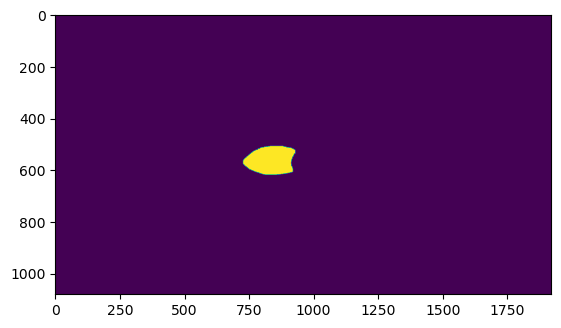

In [276]:
overrap_list = []
for j in np.unique(labels):
    temp_overrap_list = []
    zero_mask = np.zeros([test.masks.shape[0],test.masks.shape[1]])
    zero_mask[repro_points[labels==j][:,1], repro_points[labels==j][:,0]] = 1

    for i in range(test.masks.shape[2]):
        #print(np.sum((zero_mask.flatten()>0) * (masks[:,:,i].flatten()>0)))
        temp_overrap_list.append(np.sum((zero_mask.flatten()>0) * (test.masks[:,:,i].flatten()>0)))
    overrap_list.append(temp_overrap_list)

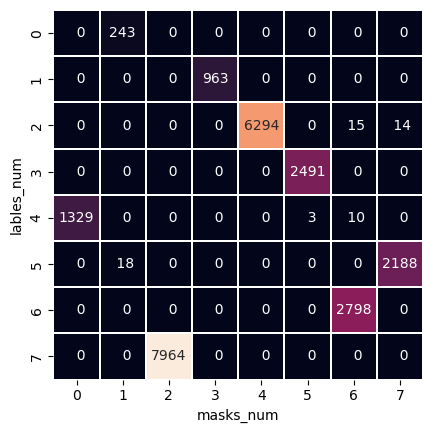

In [277]:
import seaborn as sns
ax = sns.heatmap(overrap_list, linewidth=0.3, cbar=False, annot=True, fmt="3g")
ax.set(ylabel='lables_num', xlabel='masks_num', aspect='equal')
plt.show()